### Imports

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence

import pickle
import os
import numpy as np

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import inflect
from nltk.corpus import stopwords
from scipy.stats import pearsonr
from nltk.tokenize.treebank import TreebankWordDetokenizer
import contractions
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from prettytable import PrettyTable
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


### Data Loading

In [ ]:
df_train = pd.read_json("/content/drive/MyDrive/test-ml/snli_1.0_train.jsonl", lines=True)
print(f"number of rows: {df_train.shape[0]}")
print(f"number of columns: {df_train.shape[1]}")
df_train.head()

number of rows: 550152
number of columns: 10


,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,[neutral],3416050480.jpg#4,neutral,3416050480.jpg#4r1n,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,A person is training his horse for a competition.,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
1,[contradiction],3416050480.jpg#4,contradiction,3416050480.jpg#4r1c,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,"A person is at a diner, ordering an omelette.",( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
2,[entailment],3416050480.jpg#4,entailment,3416050480.jpg#4r1e,A person on a horse jumps over a broken down a...,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,"A person is outdoors, on a horse.","( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...
3,[neutral],2267923837.jpg#2,neutral,2267923837.jpg#2r1n,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at c...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,They are smiling at their parents,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...
4,[entailment],2267923837.jpg#2,entailment,2267923837.jpg#2r1e,Children smiling and waving at camera,( Children ( ( ( smiling and ) waving ) ( at c...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,There are children present,( There ( ( are children ) present ) ),(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...


In [ ]:
df_val = pd.read_json("/content/drive/MyDrive/test-ml/snli_1.0_dev.jsonl", lines=True)
print(f"number of rows: {df_val.shape[0]}")
print(f"number of columns: {df_val.shape[1]}")
df_val.head()

number of rows: 10000
number of columns: 10


,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, entailment, neutral, neutral, neutral]",4705552913.jpg#2,neutral,4705552913.jpg#2r1n,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,The sisters are hugging goodbye while holding ...,( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...
1,"[entailment, entailment, entailment, entailmen...",4705552913.jpg#2,entailment,4705552913.jpg#2r1e,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,Two woman are holding packages.,( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...
2,"[contradiction, contradiction, contradiction, ...",4705552913.jpg#2,contradiction,4705552913.jpg#2r1c,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,The men are fighting outside a deli.,( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...
3,"[entailment, entailment, entailment, entailmen...",2407214681.jpg#0,entailment,2407214681.jpg#0r1e,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids in numbered jerseys wash their hands.,( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...
4,"[neutral, neutral, neutral, entailment, entail...",2407214681.jpg#0,neutral,2407214681.jpg#0r1n,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids at a ballgame wash their hands.,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...


In [ ]:
df_test = pd.read_json("/content/drive/MyDrive/test-ml/snli_1.0_test.jsonl", lines=True)
print(f"number of rows: {df_test.shape[0]}")
print(f"number of columns: {df_test.shape[1]}")
df_test.head()

number of rows: 10000
number of columns: 10


,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, contradiction, contradiction, neutra...",2677109430.jpg#1,neutral,2677109430.jpg#1r1n,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,The church has cracks in the ceiling.,( ( The church ) ( ( has ( cracks ( in ( the c...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ ha...
1,"[entailment, entailment, entailment, neutral, ...",2677109430.jpg#1,entailment,2677109430.jpg#1r1e,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,The church is filled with song.,( ( The church ) ( ( is ( filled ( with song )...,(ROOT (S (NP (DT The) (NN church)) (VP (VBZ is...
2,"[contradiction, contradiction, contradiction, ...",2677109430.jpg#1,contradiction,2677109430.jpg#1r1c,This church choir sings to the masses as they ...,( ( This ( church choir ) ) ( ( ( sings ( to (...,(ROOT (S (NP (DT This) (NN church) (NN choir))...,A choir singing at a baseball game.,( ( ( A choir ) ( singing ( at ( a ( baseball ...,(ROOT (NP (NP (DT A) (NN choir)) (VP (VBG sing...
3,"[neutral, neutral, neutral, neutral, neutral]",6160193920.jpg#4,neutral,6160193920.jpg#4r1n,"A woman with a green headscarf, blue shirt and...",( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,The woman is young.,( ( The woman ) ( ( is young ) . ) ),(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...
4,"[entailment, entailment, contradiction, entail...",6160193920.jpg#4,entailment,6160193920.jpg#4r1e,"A woman with a green headscarf, blue shirt and...",( ( ( A woman ) ( with ( ( ( ( ( a ( green hea...,(ROOT (NP (NP (DT A) (NN woman)) (PP (IN with)...,The woman is very happy.,( ( The woman ) ( ( is ( very happy ) ) . ) ),(ROOT (S (NP (DT The) (NN woman)) (VP (VBZ is)...


### Data Preprocessing and Visualizations

Now let's define a few functions needed for data preprocessing. The first one will be the one that will leave only usefull columns to work with, them being gold_label (with label of relation between sentences), sentence1 (premise) and sentence2 (hypothesis)

In [ ]:
def remove_unnecessary_data(df):
  """Remove unnecessary columns and Nan values from dataset"""
  if not df.columns.isin(['gold_label', 'sentence1','sentence2']).any():
    raise ValueError('Dataframe not correct: columns gold_label, sentence1,sentence2 should exist in dataframe')
  df = df[['gold_label', 'sentence1','sentence2']]
  df = df[df["gold_label"] != "-"]
  df = df.rename(columns={'gold_label': 'label'})
  df = df.dropna().reset_index(drop=True)
  return df

Now let's perform such transformation for all 3 datasets

In [ ]:
snli_data_train = remove_unnecessary_data(df_train)
snli_data_train.head()

,label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


In [ ]:
snli_data_val = remove_unnecessary_data(df_val)
snli_data_val.head()

,label,sentence1,sentence2
0,neutral,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...
1,entailment,Two women are embracing while holding to go pa...,Two woman are holding packages.
2,contradiction,Two women are embracing while holding to go pa...,The men are fighting outside a deli.
3,entailment,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.
4,neutral,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.


In [ ]:
snli_data_test = remove_unnecessary_data(df_test)
snli_data_test.head()

,label,sentence1,sentence2
0,neutral,This church choir sings to the masses as they ...,The church has cracks in the ceiling.
1,entailment,This church choir sings to the masses as they ...,The church is filled with song.
2,contradiction,This church choir sings to the masses as they ...,A choir singing at a baseball game.
3,neutral,"A woman with a green headscarf, blue shirt and...",The woman is young.
4,entailment,"A woman with a green headscarf, blue shirt and...",The woman is very happy.


As we can see, the transformation works, thus we can now perform more advanced one to get the data for further model trainings and validation.

In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', ' ', word)
        if new_word != ' ':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [ ]:
def normalize_data(words):
  words = remove_non_ascii(words)
  words = to_lowercase(words)
  words = remove_punctuation(words)
  words = replace_numbers(words)
  words = remove_stopwords(words)
  return words

def preprocess_data(sentence):
  """Perform all steps needed to normalize data"""
  sentence = remove_URL(sentence)
  sentence = replace_contractions(sentence)
  # Tokenize
  words = nltk.word_tokenize(sentence)
  # Normalize 
  words = normalize_data(words)
  words = TreebankWordDetokenizer().detokenize(words)
  return words

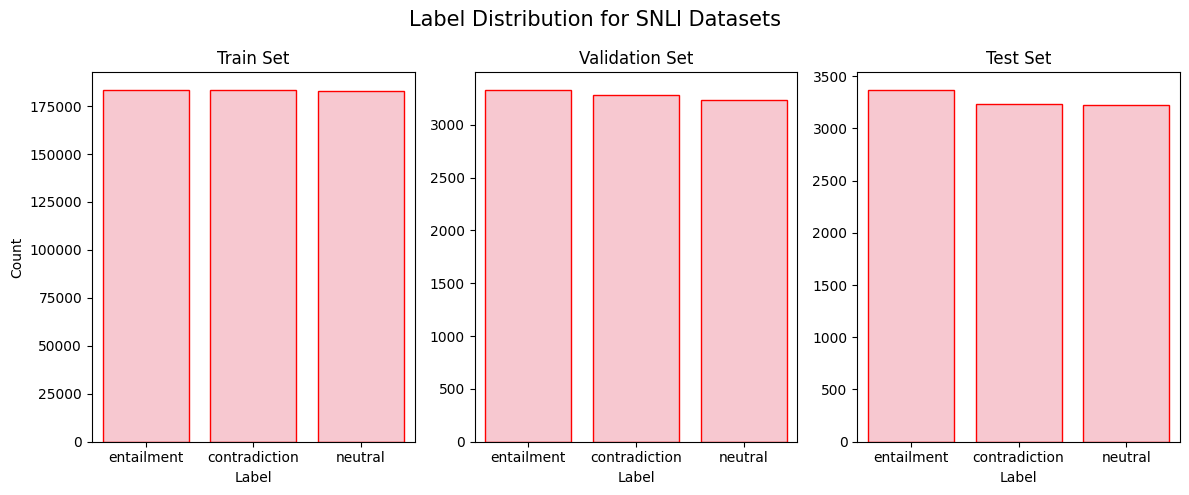

In [ ]:
# Set up the figure and subplots
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Plot the count plots for train, validation-test matched and mismatched sets
sns.countplot(x='label', data=snli_data_train, order=snli_data_train['label'].value_counts().index, color='pink', edgecolor='red', ax=axs[0])
sns.countplot(x='label', data=snli_data_val, order=snli_data_val['label'].value_counts().index, color='pink', edgecolor='red', ax=axs[1])
sns.countplot(x='label', data=snli_data_test, order=snli_data_test['label'].value_counts().index, color='pink', edgecolor='red', ax=axs[2])

# Set the titles and labels for each subplot
axs[0].set_title('Train Set')
axs[1].set_title('Validation Set')
axs[2].set_title('Test Set')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_xlabel('Label')
axs[1].set_xlabel('Label')
axs[2].set_xlabel('Label')

# Add a suptitle for all three plots
fig.suptitle('Label Distribution for SNLI Datasets', fontsize=15)

# Adjust the layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plots
plt.show()

Since our train dataset contains ~ 550k rows, and as we see we have a proper distribution of labels, as well as in the validation and test data!

Let's finally normalize our datasets! It will take a while because of the amount of data we have, starting from train set

In [ ]:
snli_data_train['premise'] = snli_data_train.apply(lambda x: preprocess_data(x.sentence1), axis=1)
snli_data_train['hypothesis'] = snli_data_train.apply(lambda x: preprocess_data(x.sentence2), axis=1)
snli_data_train.head()

In [ ]:
snli_data_train = snli_data_train.drop(['sentence1', 'sentence2'], axis=1)
snli_data_train.head()

,label,premise,hypothesis
0,neutral,person horse jumps broken airplane,person training horse competition
1,contradiction,person horse jumps broken airplane,person diner ordering omelette
2,entailment,person horse jumps broken airplane,person outdoors horse
3,neutral,children smiling waving camera,smiling parents
4,entailment,children smiling waving camera,children present


Now let's do the same but for validation and test sets

In [16]:
snli_data_val['premise'] = snli_data_val.apply(lambda x: preprocess_data(x.sentence1), axis=1)
snli_data_val['hypothesis'] = snli_data_val.apply(lambda x: preprocess_data(x.sentence2), axis=1)
snli_data_val.head()

,label,sentence1,sentence2,premise,hypothesis
0,neutral,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,two women embracing holding go packages,sisters hugging goodbye holding go packages ea...
1,entailment,Two women are embracing while holding to go pa...,Two woman are holding packages.,two women embracing holding go packages,two woman holding packages
2,contradiction,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,two women embracing holding go packages,men fighting outside deli
3,entailment,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,two young children blue jerseys one number nin...,two kids numbered jerseys wash hands
4,neutral,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,two young children blue jerseys one number nin...,two kids ballgame wash hands


In [17]:
snli_data_val = snli_data_val.drop(['sentence1', 'sentence2'], axis=1)
snli_data_val.head()

,label,premise,hypothesis
0,neutral,two women embracing holding go packages,sisters hugging goodbye holding go packages ea...
1,entailment,two women embracing holding go packages,two woman holding packages
2,contradiction,two women embracing holding go packages,men fighting outside deli
3,entailment,two young children blue jerseys one number nin...,two kids numbered jerseys wash hands
4,neutral,two young children blue jerseys one number nin...,two kids ballgame wash hands


In [18]:
snli_data_test['premise'] = snli_data_test.apply(lambda x: preprocess_data(x.sentence1), axis=1)
snli_data_test['hypothesis'] = snli_data_test.apply(lambda x: preprocess_data(x.sentence2), axis=1)
snli_data_test.head()

,label,sentence1,sentence2,premise,hypothesis
0,neutral,This church choir sings to the masses as they ...,The church has cracks in the ceiling.,church choir sings masses sing joyous songs bo...,church cracks ceiling
1,entailment,This church choir sings to the masses as they ...,The church is filled with song.,church choir sings masses sing joyous songs bo...,church filled song
2,contradiction,This church choir sings to the masses as they ...,A choir singing at a baseball game.,church choir sings masses sing joyous songs bo...,choir singing baseball game
3,neutral,"A woman with a green headscarf, blue shirt and...",The woman is young.,woman green headscarf blue shirt big grin,woman young
4,entailment,"A woman with a green headscarf, blue shirt and...",The woman is very happy.,woman green headscarf blue shirt big grin,woman happy


In [19]:
snli_data_test = snli_data_test.drop(['sentence1', 'sentence2'], axis=1)
snli_data_test.head()

,label,premise,hypothesis
0,neutral,church choir sings masses sing joyous songs bo...,church cracks ceiling
1,entailment,church choir sings masses sing joyous songs bo...,church filled song
2,contradiction,church choir sings masses sing joyous songs bo...,choir singing baseball game
3,neutral,woman green headscarf blue shirt big grin,woman young
4,entailment,woman green headscarf blue shirt big grin,woman happy


Now let's analyze what is the situation with word count for our hypothesis and premise columns for train dataset. We will create columns for word count for both premise and hypothesis columns. Let's look what we have as a result

In [20]:
snli_data_train['premise_word_count'] = snli_data_train['premise'].apply(lambda x: len(str(x).split()))
snli_data_val['premise_word_count'] = snli_data_val['premise'].apply(lambda x: len(str(x).split()))
snli_data_test['premise_word_count'] = snli_data_test['premise'].apply(lambda x: len(str(x).split()))

snli_data_train['hypothesis_word_count'] = snli_data_train['hypothesis'].apply(lambda x: len(str(x).split()))
snli_data_val['hypothesis_word_count'] = snli_data_val['hypothesis'].apply(lambda x: len(str(x).split()))
snli_data_test['hypothesis_word_count'] = snli_data_test['hypothesis'].apply(lambda x: len(str(x).split()))
snli_data_train

,label,premise,hypothesis,premise_word_count,hypothesis_word_count
0,neutral,person horse jumps broken airplane,person training horse competition,5,4
1,contradiction,person horse jumps broken airplane,person diner ordering omelette,5,4
2,entailment,person horse jumps broken airplane,person outdoors horse,5,3
3,neutral,children smiling waving camera,smiling parents,4,2
4,entailment,children smiling waving camera,children present,4,2
...,...,...,...,...,...
549362,contradiction,four dirty barefooted children,four kids awards cleanest feet,4,5
549363,neutral,four dirty barefooted children,four homeless children shoes stolen feet dirty,4,7
549364,neutral,man surfing bodysuit beautiful blue water,man bodysuit competing surfing competition,6,5
549365,contradiction,man surfing bodysuit beautiful blue water,man business suit heading board meeting,6,6


The same for validation and test datasets

In [21]:
snli_data_val

,label,premise,hypothesis,premise_word_count,hypothesis_word_count
0,neutral,two women embracing holding go packages,sisters hugging goodbye holding go packages ea...,6,8
1,entailment,two women embracing holding go packages,two woman holding packages,6,4
2,contradiction,two women embracing holding go packages,men fighting outside deli,6,4
3,entailment,two young children blue jerseys one number nin...,two kids numbered jerseys wash hands,18,6
4,neutral,two young children blue jerseys one number nin...,two kids ballgame wash hands,18,5
...,...,...,...,...,...
9837,entailment,small girl wearing pink jacket riding carousel,carousel moving,7,2
9838,contradiction,small girl wearing pink jacket riding carousel,girl moving speed light,7,4
9839,entailment,young girl blue pink ribbons braids without to...,people water fountain,18,3
9840,contradiction,young girl blue pink ribbons braids without to...,young girl knits sweater,18,4


In [22]:
snli_data_test

,label,premise,hypothesis,premise_word_count,hypothesis_word_count
0,neutral,church choir sings masses sing joyous songs bo...,church cracks ceiling,9,3
1,entailment,church choir sings masses sing joyous songs bo...,church filled song,9,3
2,contradiction,church choir sings masses sing joyous songs bo...,choir singing baseball game,9,4
3,neutral,woman green headscarf blue shirt big grin,woman young,7,2
4,entailment,woman green headscarf blue shirt big grin,woman happy,7,2
...,...,...,...,...,...
9819,contradiction,two women observing something together,two women standing eyes closed,5,5
9820,entailment,two women observing something together,two girls looking something,5,4
9821,contradiction,man black leather jacket book hand speaks clas...,man flying kite,8,3
9822,entailment,man black leather jacket book hand speaks clas...,man speaking classroom,8,3


Now let's try to see the overall picture for datasets by plotting word counts for premises and hypothesis word counts and see their distribution

In [23]:
def plot_word_count(data, title):
    """Create a plot with two subplots, one for the premise text word counts
        and one for the hypothesis text word counts."""
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    bins_prem = int(data['premise_word_count'].max()/2)
    bins_hyp = int(data['hypothesis_word_count'].max())
    
    # Plot the premise text word counts
    axs[0].hist(data['premise_word_count'], bins=bins_prem, color='red', linewidth=0.5, edgecolor='black', rwidth=0.8)
    axs[0].set_xlabel('Sentences word count')
    axs[0].set_ylabel('Count')
    axs[0].set_title('Premise')
    
    # Plot the hypothesis text word counts
    axs[1].hist(data['hypothesis_word_count'], bins=bins_hyp, color='blue', linewidth=0.5, edgecolor='black', rwidth=0.8)
    axs[1].set_xlabel('Sentences word count')
    axs[1].set_ylabel('Count')
    axs[1].set_title('Hypothesis')
    
    # Set the overall title
    fig.suptitle(title, fontsize=14)
    
    # Adjust the spacing between subplots
    fig.tight_layout()
    
    # Show the plot
    plt.show()

Let's firstly do for out train dataset

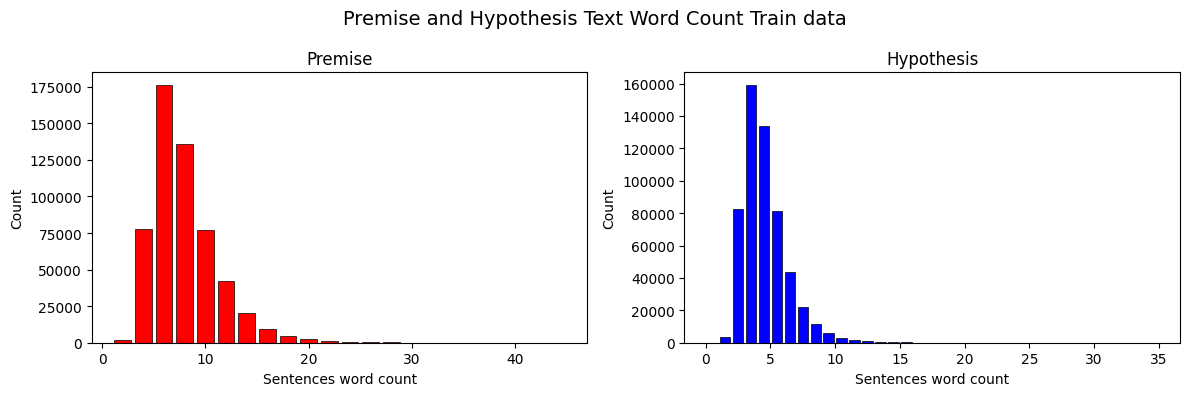

In [24]:
plot_word_count(snli_data_train, 'Premise and Hypothesis Text Word Count Train data')

Now for validation data

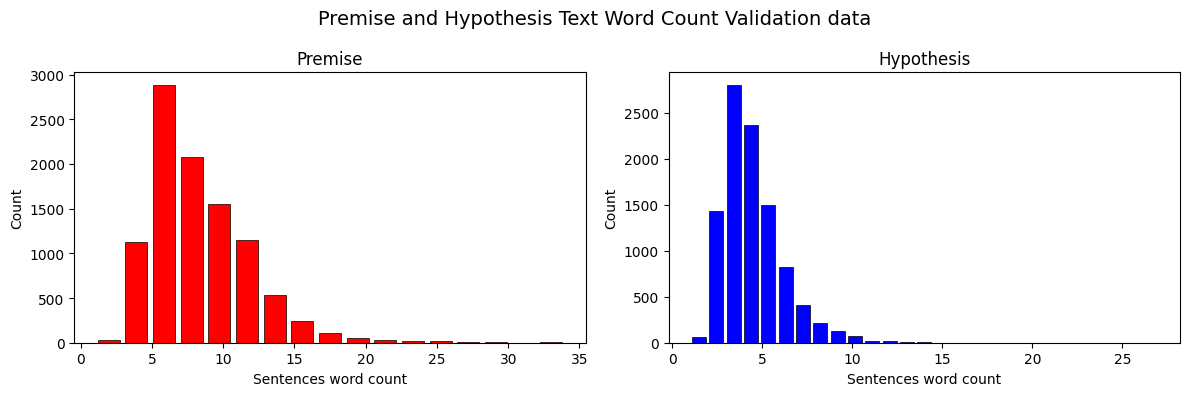

In [25]:
plot_word_count(snli_data_val, 'Premise and Hypothesis Text Word Count Validation data')

And test data

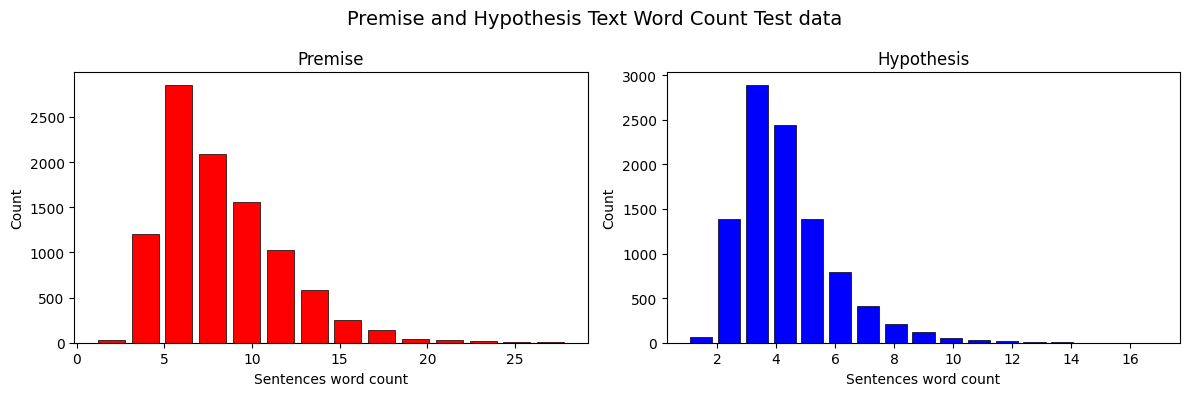

In [26]:
plot_word_count(snli_data_test, 'Premise and Hypothesis Text Word Count Test data')

Okay, now we are interested in statistics. What are the percentiles of word count for both hypothesis and premises for all datasets? In such way we can see how long are usually our normalized sentences

In [27]:
def print_percentile_table(df, name):
  """Takes a Pandas DataFrame column as input and prints a pretty table with
      percentile information on a specific column of the DataFrame
  """
  # Compute the percentiles and max length
  percentiles = df.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995, 0.999])
  max_length = df.max()

  # Create a pretty table for the results
  table = PrettyTable()
  table.field_names = ['Percentile', f'{name} Length']
  for p in percentiles.index:
      table.add_row([f'{round(p*100, 3)}%', f'{int(percentiles[p])}'])
  table.add_row(['Max', f'{int(max_length)}'])

  # Print the table
  return(str(table))

Let's see firstly the stats for train dataset

In [28]:
# Create a list of tables to print side by side
tables = [
    print_percentile_table(snli_data_train['premise_word_count'], 'Train Premise'),
    print_percentile_table(snli_data_train['hypothesis_word_count'], 'Train Hypothesis')
]

# Print the tables side by side
print(tabulate([tables], headers=['', ''], tablefmt='plain',  numalign='center'))


+------------+----------------------+  +------------+-------------------------+
| Percentile | Train Premise Length |  | Percentile | Train Hypothesis Length |
+------------+----------------------+  +------------+-------------------------+
|   10.0%    |          4           |  |   10.0%    |            2            |
|   25.0%    |          5           |  |   25.0%    |            3            |
|   50.0%    |          7           |  |   50.0%    |            4            |
|   75.0%    |          9           |  |   75.0%    |            5            |
|   90.0%    |          12          |  |   90.0%    |            6            |
|   95.0%    |          13          |  |   95.0%    |            7            |
|   99.0%    |          18          |  |   99.0%    |            10           |
|   99.5%    |          20          |  |   99.5%    |            11           |
|   99.9%    |          26          |  |   99.9%    |            14           |
|    Max     |          45          |  

Okay, we have that out of all premise sentences, the longest ones are at most 45 words long, while for hypothesis such statistics is 35, and 99.9% of the data is at most 14 words long. Let's look now at validation dataset.

In [29]:
tables = [
    print_percentile_table(snli_data_val['premise_word_count'], 'Validation Premise'),
    print_percentile_table(snli_data_val['hypothesis_word_count'], 'Validation Hypothesis')
]
print(tabulate([tables], headers=['', ''], tablefmt='plain',  numalign='center'))


+------------+---------------------------+  +------------+------------------------------+
| Percentile | Validation Premise Length |  | Percentile | Validation Hypothesis Length |
+------------+---------------------------+  +------------+------------------------------+
|   10.0%    |             4             |  |   10.0%    |              2               |
|   25.0%    |             5             |  |   25.0%    |              3               |
|   50.0%    |             7             |  |   50.0%    |              4               |
|   75.0%    |             10            |  |   75.0%    |              5               |
|   90.0%    |             13            |  |   90.0%    |              6               |
|   95.0%    |             14            |  |   95.0%    |              7               |
|   99.0%    |             20            |  |   99.0%    |              10              |
|   99.5%    |             23            |  |   99.5%    |              11              |
|   99.9%

here 99.9-th percentile for premise sentences is 34, while for hypothesis - 14. The results very similar almost the same as for train set. Now let's look at test data!

In [30]:
tables = [
    print_percentile_table(snli_data_test['premise_word_count'], 'Test Premise'),
    print_percentile_table(snli_data_test['hypothesis_word_count'], 'Test Hypothesis')
]
print(tabulate([tables], headers=['', ''], tablefmt='plain',  numalign='center'))


+------------+---------------------+  +------------+------------------------+
| Percentile | Test Premise Length |  | Percentile | Test Hypothesis Length |
+------------+---------------------+  +------------+------------------------+
|   10.0%    |          4          |  |   10.0%    |           2            |
|   25.0%    |          5          |  |   25.0%    |           3            |
|   50.0%    |          7          |  |   50.0%    |           4            |
|   75.0%    |          10         |  |   75.0%    |           5            |
|   90.0%    |          13         |  |   90.0%    |           6            |
|   95.0%    |          15         |  |   95.0%    |           7            |
|   99.0%    |          19         |  |   99.0%    |           10           |
|   99.5%    |          21         |  |   99.5%    |           11           |
|   99.9%    |          26         |  |   99.9%    |           14           |
|    Max     |          28         |  |    Max     |           

Again, very close statistics - 99.9th percentile for premise = 26 and for hypothesis it is 14. 

As we can see, at most our data has 45 word count among all datasets, thus let's trim the sentences to have at most a bit more - 55 words.

In [31]:
def trim_sentence(sentence, max_length):
  """Trim the sentence to have an appropriate number of words (not greater
      than max number)."""
  try:
    sentence = sentence.split()
    sentence = sentence[:max_length]
    return " ".join(sentence)
  except:
    return sentence

Let's apply "trimming" for all 3 datasets now:)

In [32]:
max_length = 55
snli_data_train['premise'] = snli_data_train['premise'].apply(lambda x: trim_sentence(x, max_length))
snli_data_train['hypothesis'] = snli_data_train['hypothesis'].apply(lambda x: trim_sentence(x, max_length))

In [33]:
snli_data_val['premise'] = snli_data_val['premise'].apply(lambda x: trim_sentence(x, max_length))
snli_data_val['hypothesis'] = snli_data_val['hypothesis'].apply(lambda x: trim_sentence(x, max_length))

In [34]:
snli_data_test['premise'] = snli_data_test['premise'].apply(lambda x: trim_sentence(x, max_length))
snli_data_test['hypothesis'] = snli_data_test['hypothesis'].apply(lambda x: trim_sentence(x, max_length))

Now let's see whether it works. We can take a look now at new snli_data_train dataset and see its word count stats and plot the plots we used before

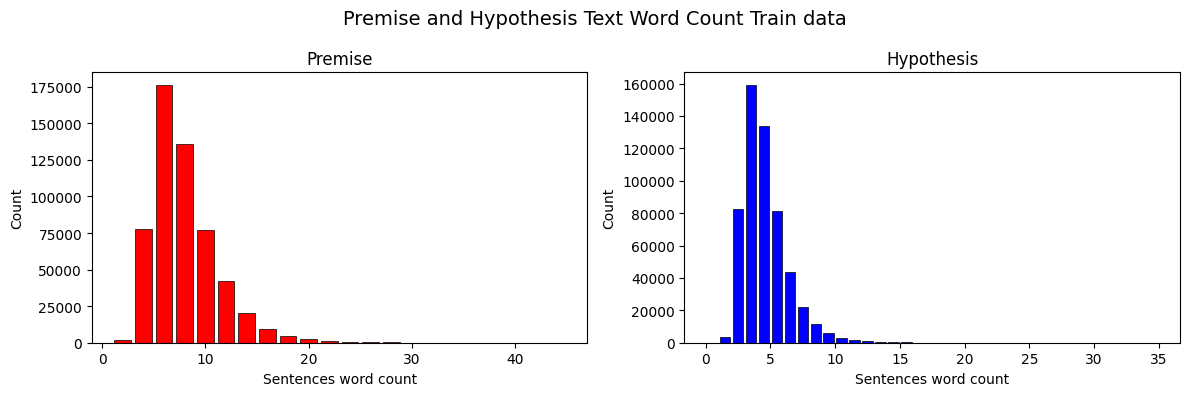

In [35]:
snli_data_train['premise_word_count'] = snli_data_train['premise'].apply(lambda x: len(str(x).split()))

snli_data_train['hypothesis_word_count'] = snli_data_train['hypothesis'].apply(lambda x: len(str(x).split()))

plot_word_count(snli_data_train, 'Premise and Hypothesis Text Word Count Train data')

Now let's look at precise stats

In [36]:
tables = [
    print_percentile_table(snli_data_train['premise_word_count'], 'Train Premise'),
    print_percentile_table(snli_data_train['hypothesis_word_count'], 'Train Hypothesis')
]
print(tabulate([tables], headers=['', ''], tablefmt='plain',  numalign='center'))


+------------+----------------------+  +------------+-------------------------+
| Percentile | Train Premise Length |  | Percentile | Train Hypothesis Length |
+------------+----------------------+  +------------+-------------------------+
|   10.0%    |          4           |  |   10.0%    |            2            |
|   25.0%    |          5           |  |   25.0%    |            3            |
|   50.0%    |          7           |  |   50.0%    |            4            |
|   75.0%    |          9           |  |   75.0%    |            5            |
|   90.0%    |          12          |  |   90.0%    |            6            |
|   95.0%    |          13          |  |   95.0%    |            7            |
|   99.0%    |          18          |  |   99.0%    |            10           |
|   99.5%    |          20          |  |   99.5%    |            11           |
|   99.9%    |          26          |  |   99.9%    |            14           |
|    Max     |          45          |  

Another important thing is now to look at the length of sentences for each label, so that the model does not learns that some label is mostly shorter/longer than others, thus potentially making more mistakes during prediction of values. Let's look at the statistics for each label for our train dataset.

In [37]:
# Define a function to compute word count
def word_count(sentence):
    words = sentence.split()
    return len(words)

def label_stats_table(df, col_name):
    # Compute word count for each sentence
    count_col_name = f'{col_name}_word_count'
    df[count_col_name] = df[col_name].apply(word_count)

    # Compute stats for each label and column
    label_stats = {}
    for label in sorted(df['label'].unique()):
        subset = df[df['label'] == label]
        label_stats[label] = {'min': subset[count_col_name].min(),
                              'max': subset[count_col_name].max(),
                              'mean': subset[count_col_name].mean(),
                              'std': subset[count_col_name].std(),
                              '50th percentile': np.percentile(subset[count_col_name], 50),
                              '90th percentile': np.percentile(subset[count_col_name], 90),
                              '99th percentile': np.percentile(subset[count_col_name], 99),
                              'count': len(subset)}

    # Create a table with the stats for each label and column
    headers = ['Label', f'Min', f'Max', f'Mean', f'Std', f'50th Percentile', f'90th Percentile', f'99th Percentile', 'Count']
    table = []
    for label in label_stats:
        row = [label]
        for stat in label_stats[label]:
            row.append(label_stats[label][stat])
        table.append(row)

    # Print the table with centered alignment
    print(tabulate(table, headers=headers, tablefmt='fancy_grid', colalign=('center', 'center', 'center', 'center', 'center', 'center', 'center', 'center', 'center')))


In [38]:
label_stats_table(snli_data_train, 'premise')

╒═══════════════╤═══════╤═══════╤═════════╤═════════╤═══════════════════╤═══════════════════╤═══════════════════╤═════════╕
│     Label     │  Min  │  Max  │  Mean   │   Std   │  50th Percentile  │  90th Percentile  │  99th Percentile  │  Count  │
╞═══════════════╪═══════╪═══════╪═════════╪═════════╪═══════════════════╪═══════════════════╪═══════════════════╪═════════╡
│ contradiction │   1   │  45   │ 7.42658 │ 3.21895 │         7         │        12         │        18         │ 183187  │
├───────────────┼───────┼───────┼─────────┼─────────┼───────────────────┼───────────────────┼───────────────────┼─────────┤
│  entailment   │   1   │  45   │ 7.4262  │ 3.21816 │         7         │        12         │        18         │ 183416  │
├───────────────┼───────┼───────┼─────────┼─────────┼───────────────────┼───────────────────┼───────────────────┼─────────┤
│    neutral    │   1   │  45   │ 7.42618 │ 3.21989 │         7         │        12         │        18         │ 182764  │
╘═══════

In [39]:
label_stats_table(snli_data_train, 'hypothesis')

╒═══════════════╤═══════╤═══════╤═════════╤═════════╤═══════════════════╤═══════════════════╤═══════════════════╤═════════╕
│     Label     │  Min  │  Max  │  Mean   │   Std   │  50th Percentile  │  90th Percentile  │  99th Percentile  │  Count  │
╞═══════════════╪═══════╪═══════╪═════════╪═════════╪═══════════════════╪═══════════════════╪═══════════════════╪═════════╡
│ contradiction │   0   │  31   │ 4.01224 │ 1.60983 │         4         │         6         │         9         │ 183187  │
├───────────────┼───────┼───────┼─────────┼─────────┼───────────────────┼───────────────────┼───────────────────┼─────────┤
│  entailment   │   0   │  25   │ 3.6222  │ 1.55015 │         3         │         6         │         9         │ 183416  │
├───────────────┼───────┼───────┼─────────┼─────────┼───────────────────┼───────────────────┼───────────────────┼─────────┤
│    neutral    │   0   │  35   │ 4.47794 │ 1.92778 │         4         │         7         │        11         │ 182764  │
╘═══════

As you can see, for both hypothesis and premise sentences, we have very close statistics for each label, so there is no "longer" or "shorter" label in our dataset :)

Now let's save our preprocessed datasets to separate csv files. But firstly we will drop unnecessary columns premise_word_count and hypothesis_word_count (as we needed them only for statistics and analysis)

In [40]:
snli_data_train.drop(['premise_word_count', 'hypothesis_word_count'], axis=1, inplace=True)

Check whether it worked

In [41]:
snli_data_train.head()

,label,premise,hypothesis
0,neutral,person horse jumps broken airplane,person training horse competition
1,contradiction,person horse jumps broken airplane,person diner ordering omelette
2,entailment,person horse jumps broken airplane,person outdoors horse
3,neutral,children smiling waving camera,smiling parents
4,entailment,children smiling waving camera,children present


Do the same for validation and test datasets

In [42]:
snli_data_val.drop(['premise_word_count', 'hypothesis_word_count'], axis=1, inplace=True)
snli_data_test.drop(['premise_word_count', 'hypothesis_word_count'], axis=1, inplace=True)

In [43]:
snli_data_val.head()

,label,premise,hypothesis
0,neutral,two women embracing holding go packages,sisters hugging goodbye holding go packages ea...
1,entailment,two women embracing holding go packages,two woman holding packages
2,contradiction,two women embracing holding go packages,men fighting outside deli
3,entailment,two young children blue jerseys one number nin...,two kids numbered jerseys wash hands
4,neutral,two young children blue jerseys one number nin...,two kids ballgame wash hands


In [44]:
snli_data_test.head()

,label,premise,hypothesis
0,neutral,church choir sings masses sing joyous songs bo...,church cracks ceiling
1,entailment,church choir sings masses sing joyous songs bo...,church filled song
2,contradiction,church choir sings masses sing joyous songs bo...,choir singing baseball game
3,neutral,woman green headscarf blue shirt big grin,woman young
4,entailment,woman green headscarf blue shirt big grin,woman happy


### Save preprocessed data

Save data to Drive folder and we are done

In [45]:
snli_data_train.to_csv('/content/drive/MyDrive/test-ml/snli_data_train.csv', index=False)
snli_data_val.to_csv('/content/drive/MyDrive/test-ml/snli_data_val.csv', index=False)
snli_data_test.to_csv('/content/drive/MyDrive/test-ml/snli_data_test.csv', index=False)